# 1. Run this stuff

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime
import geopy
from geopy.geocoders import Nominatim
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
import folium
import warnings
warnings.filterwarnings('ignore')

Some magic that tells jupyter to put graphs and things in the notebook instead of the default behaviour which is to save it as a file.

In [2]:
%matplotlib inline

In [3]:
if os.path.isfile("international_air_traffic_data_set.csv"):
    filepath = "international_air_traffic_data_set.csv"
    print("loading from file")
else:
    filepath = "https://data.gov.au/data/dataset/d9fbffaa-836f-4f52-80e8-324249ff269f/resource/ebcafd83-9514-4f72-a995-fe7ee90cb9da/download/city_pairs.csv"
    print("loading from the internet")

international_air_traffic_data_set = pd.read_csv(filepath)
print("done")

loading from file
done


In [4]:
df = pd.read_csv("international_air_traffic_data_set.csv")

Add extra column that converts month number to name

In [5]:
 df["Month_name"] = pd.to_datetime(df["Month_num"], format='%m').dt.month_name().str.slice(stop=3)

This goes to the internet and grabs the long and lat for the cities

Grabs the unique items from the column we just made

In [6]:
#import all these - in the link it shows you how to install them
import pandas as pd
import geopy
from geopy.geocoders import Nominatim

#I don't really understand code but this line makes it all work
geolocator = Nominatim(timeout=10, user_agent = "myGeolocator")

#This is just me reading in my data frame
df = pd.read_csv("international_air_traffic_data_set.csv")

# This concatinates the columns for city name and country - e.g. Auckland, New Zealand

df["full_address"] = df.ForeignPort + ", " + df.Country

# My data frame has over 82000 rows, so I only want to look for the unique cities because there are only 203
# therefore less time waiting for all the data to load
unique_ports = df.full_address.unique()

# here im creating "buckets" or "empty lists" to fill in the data that comes back from the api
lat = []
lon = []
ports = []
locations = []

# This loop goes through each city in the "unique cities" list and get the geocode data from the internet
for port in unique_ports:
    try:
        location = geolocator.geocode(port)
        lat.append(location.latitude)
        lon.append(location.longitude)
        locations.append(location)
        ports.append(port)
        print(location.longitude, location.latitude)
    except:
        # i put in an except loop because sometimes the api doesnt recognise a city name
        # if it return no value then it prints the name of the city it couldnt find
        # im having some trouble at the moment with cases its getting confused somewhere along the way
        # It doesnt like "NewYork" it likes "New York" it has to have a space - somewhere my code is removing the space
        if location == None:
            # by printing "port" you can see which cities it cant find
            print(port)
# this bit takes those lists from above and puts them in a dictionary
di = {"port":ports, "locations":locations, "latitude":lat, "longitude":lon}
dz = {"latitude":lat, "longitude":lon}
# this converts the dictionary into a data frame
# port_df is the data frame that gets merged to the bigger frame later
port_df = pd.DataFrame(di)
# long_lat is a data frame that just has long and lat data
long_lat = pd.DataFrame(dz)

174.7631803 -36.852095
50.5344606 26.1551249
72.8773928 19.0759899
8.6820917 50.1106444
-0.1276474 51.5073219
58.3829448 23.5882019
12.4829321 41.8933203
103.8194992 1.357107
54.3774014 24.4538352
100.4930399 13.7544238
172.6366455 -43.530955
114.1628131 22.2793278
159.9624174786047 -9.437797549999999
-157.855676 21.304547
101.6942371 3.1516964
-118.242766 34.0536909
120.9809674 14.5907332
177.4172058 -17.7993389
166.442419 -22.2745264
147.1599504 -9.4743301
168.3150163 -17.7414972
-122.419906 37.7790262
178.4421662 -18.1415884
139.7594549 35.6828387
-123.1139529 49.2608724
174.7772114 -41.2887953
114.9417574 4.8895453
115.2191175 -8.6524973
106.827183 -6.1753942
4.8936041 52.3727598
23.7283052 37.9839412
116.3912757 39.906217
20.452295813899802 44.788099349999996
79.8541134 6.9387469
55.18853865430702 25.074282349999997
-95.3676974 29.7589382
33.6236184 34.9236095
-2.2451148 53.4794892
57.5703566 -20.2759451
166.9324426 -0.5252306
-74.0060152 40.7127281
-149.5595064 -17.5360234
31.045

Merge the new data frame with the long/lat of the unique cities

In [7]:
# I need to match the "port" column (the one we just geocoded and made) 
# with the "full_address" column we just created as a new column in the original data frame
df_long_lat = pd.merge(df, port_df, left_on='full_address', right_on='port')
df_long_lat.head()

,Month,AustralianPort,ForeignPort,Country,Passengers_In,Freight_In_(tonnes),Mail_In_(tonnes),Passengers_Out,Freight_Out_(tonnes),Mail_Out_(tonnes),Passengers_Total,Freight_Total_(tonnes),Mail_Total_(tonnes),Year,Month_num,full_address,port,locations,latitude,longitude
0,31048,Adelaide,Auckland,New Zealand,1513.0,42.167,0.311,985.0,18.704,0.924,2498.0,60.871,1.235,1985,1,"Auckland, New Zealand","Auckland, New Zealand","(Auckland, Waitematā, Auckland, 1010, New Zeal...",-36.852095,174.76318
1,31048,Brisbane,Auckland,New Zealand,7157.0,223.258,0.671,5652.0,33.032,3.218,12809.0,256.290,3.889,1985,1,"Auckland, New Zealand","Auckland, New Zealand","(Auckland, Waitematā, Auckland, 1010, New Zeal...",-36.852095,174.76318
2,31048,Darwin,Auckland,New Zealand,379.0,5.529,0.000,108.0,0.209,0.031,487.0,5.738,0.031,1985,1,"Auckland, New Zealand","Auckland, New Zealand","(Auckland, Waitematā, Auckland, 1010, New Zeal...",-36.852095,174.76318
3,31048,Melbourne,Auckland,New Zealand,6039.0,200.015,0.799,5328.0,155.065,3.726,11367.0,355.080,4.525,1985,1,"Auckland, New Zealand","Auckland, New Zealand","(Auckland, Waitematā, Auckland, 1010, New Zeal...",-36.852095,174.76318
4,31048,Norfolk Island,Auckland,New Zealand,367.0,9.708,0.288,546.0,0.120,0.122,913.0,9.828,0.410,1985,1,"Auckland, New Zealand","Auckland, New Zealand","(Auckland, Waitematā, Auckland, 1010, New Zeal...",-36.852095,174.76318


Saves this to a new csv file

Its called "modified"

In [ ]:
df_long_lat.to_csv('modified.csv', index=False)

# Presentation

# International Travel Data to/from Australia
### Anthony Franco

## I'll be presenting a data set that contains the amount freight, mail and passengers that have come into and out of Australia since 1985

## Lets take a look at the data set



In [9]:
df.head()

,Month,AustralianPort,ForeignPort,Country,Passengers_In,Freight_In_(tonnes),Mail_In_(tonnes),Passengers_Out,Freight_Out_(tonnes),Mail_Out_(tonnes),Passengers_Total,Freight_Total_(tonnes),Mail_Total_(tonnes),Year,Month_num
0,31048,Adelaide,Auckland,New Zealand,1513.0,42.167,0.311,985.0,18.704,0.924,2498.0,60.871,1.235,1985,1
1,31048,Adelaide,Bahrain,Bahrain,12.0,0.000,0.000,5.0,0.033,0.000,17.0,0.033,0.000,1985,1
2,31048,Adelaide,Bombay,India,7.0,0.000,0.000,5.0,0.000,0.000,12.0,0.000,0.000,1985,1
3,31048,Adelaide,Frankfurt,Germany,115.0,0.009,0.000,171.0,0.000,0.248,286.0,0.009,0.248,1985,1
4,31048,Adelaide,London,UK,1567.0,2.800,0.000,1472.0,10.618,2.487,3039.0,13.418,2.487,1985,1


## looking at the info for the code - are there any null values? what are the objects type?

## Some info on the dataset

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82499 entries, 0 to 82498
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Month                   82499 non-null  int64  
 1   AustralianPort          82499 non-null  object 
 2   ForeignPort             82499 non-null  object 
 3   Country                 82499 non-null  object 
 4   Passengers_In           82487 non-null  float64
 5   Freight_In_(tonnes)     82495 non-null  float64
 6   Mail_In_(tonnes)        82495 non-null  float64
 7   Passengers_Out          82489 non-null  float64
 8   Freight_Out_(tonnes)    82495 non-null  float64
 9   Mail_Out_(tonnes)       82495 non-null  float64
 10  Passengers_Total        82489 non-null  float64
 11  Freight_Total_(tonnes)  82499 non-null  float64
 12  Mail_Total_(tonnes)     82499 non-null  float64
 13  Year                    82499 non-null  int64  
 14  Month_num               82499 non-null

## How many items are in each year?

In [276]:
df.groupby("Year").size()

Year
1985    1944
1986    2224
1987    2284
1988    2361
1989    2369
1990    2471
1991    2281
1992    2469
1993    2656
1994    2600
1995    2807
1996    3035
1997    3157
1998    3162
1999    3407
2000    3502
2001    2970
2002    2769
2003    1820
2004    1877
2005    1898
2006    1830
2007    1824
2008    1792
2009    1738
2010    1791
2011    1875
2012    1808
2013    1848
2014    1786
2015    1828
2016    1949
2017    2106
2018    2240
2019    2219
2020    1373
2021     429
dtype: int64

# Graphs

Shows the amount of passengers from each country

### Distribution of Passengers

In [23]:
def pie():
    a = df.groupby("Country").size()
    a.sort_values(ascending=False)
    a.plot.pie()
    plt.title("Airtravel Pasengers", fontsize=18)
    plt.grid(False)
    plt.show()

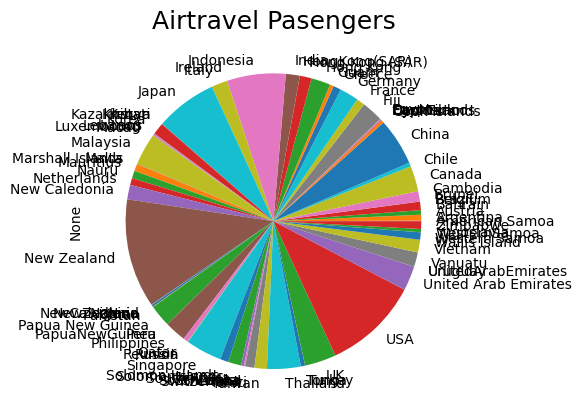

In [24]:
pie()

Most popular domestic airport

In [20]:
def most_popular_domestic_airport():
    most_pop_dom_port = df.AustralianPort.value_counts(dropna=False)
    most_pop_dom_port.plot.barh()
    plt.title("Most Popular Domestic Airports", fontsize=18)
    plt.xlabel('Airport', fontsize=15)
    plt.ylabel('Frequency of Appearance', fontsize=15)
    plt.show()

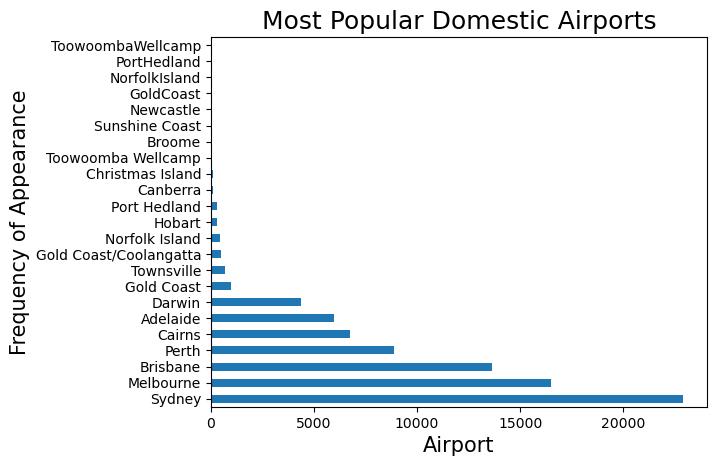

In [21]:
most_popular_domestic_airport()

### Most Popular Airports 1985

In [46]:
def most_popular_airports_compare():
    dfbar = df_long_lat[["Year", "ForeignPort", "Passengers_Total"]]
    dataforbar = dfbar[(df_long_lat.Year == 1985)]
    dfe = dataforbar["ForeignPort"].value_counts()
    dfe.rank(axis=0, method='max', ascending=True)
    top_10 = dfe.head(10)
    top_10.plot(kind='bar');
    plt.title("Most Popular Airports 1985", fontsize=15)
    plt.xlabel('Airport', fontsize=10)
    plt.ylabel('Popularity', fontsize=10)
    plt.show()

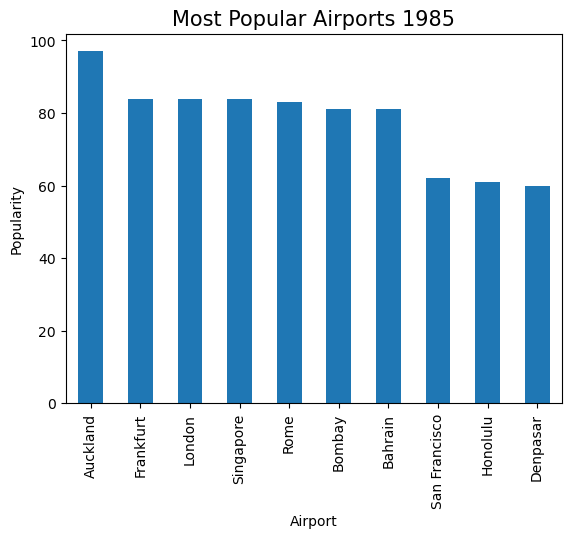

In [47]:
most_popular_airports_compare()

### Most Popular Airports 2019

In [43]:
def most_popular_airports_compare_new():
    dfbar = df_long_lat[["Year", "ForeignPort", "Passengers_Total"]]
    dataforbar = dfbar[(df_long_lat.Year == 2019)]
    dfe = dataforbar["ForeignPort"].value_counts()
    dfe.rank(axis=0, method='max', ascending=True)
    top_10 = dfe.head(10)
    top_10.plot(kind='bar');
    plt.title("Most Popular Airports 2019", fontsize=15)
    plt.xlabel('Airport', fontsize=10)
    plt.ylabel('Popularity', fontsize=10)
    plt.show()

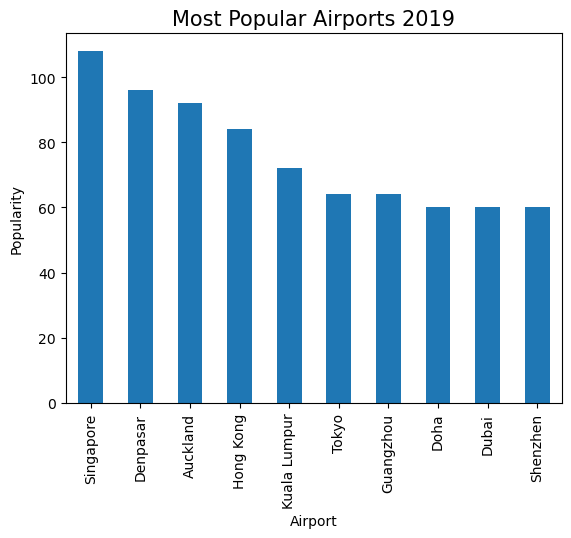

In [44]:
most_popular_airports_compare_new()

### Plots of Passengers

In [111]:
def pass_plot():
    pass_in = df[["Year","Passengers_In"]].groupby("Year").sum()
    pass_out = df[["Year","Passengers_Out"]].groupby("Year").sum()

    plt.rcdefaults()
    plt.plot(pass_in, "x-", label="Passengers Incoming")
    plt.plot(pass_out, "x-", label="Passengers Outgoing")
    plt.title("Passengers In/Out", fontsize=15)
    plt.xlabel('Year', fontsize=10)
    plt.ylabel('Passengers', fontsize=10)
    plt.legend()
    plt.grid(True)
    plt.show()

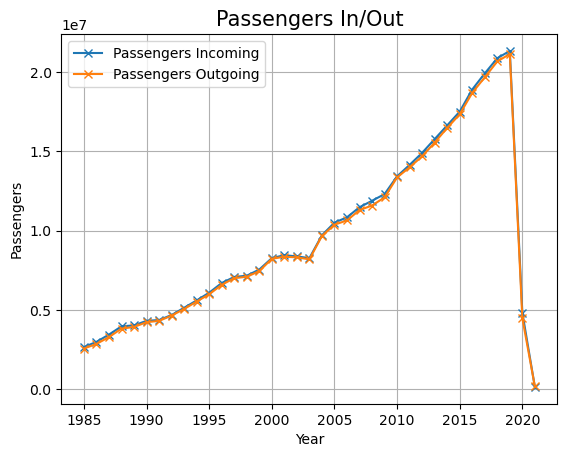

In [112]:
pass_plot()

### Freight In/Out

In [113]:
def freight():
    Freight_In = df[["Year","Freight_In_(tonnes)"]].groupby("Year").sum()
    Freight_Out = df[["Year","Freight_Out_(tonnes)"]].groupby("Year").sum()

    plt.rcdefaults()
    plt.plot(Freight_In, "x-", label = "Freight In")
    plt.plot(Freight_Out, "x-", label = "Freight Out")
    plt.title("Freight In/Out", fontsize=15)
    plt.xlabel('Year', fontsize=10)
    plt.ylabel('Freight (tonnes)', fontsize=10)
    plt.legend()

    plt.grid(True)
    plt.show()

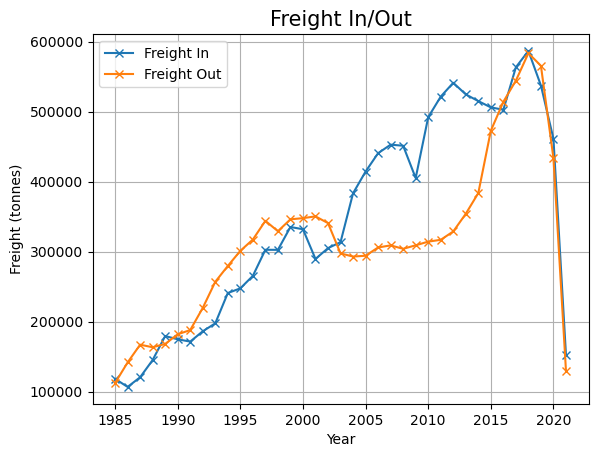

In [114]:
freight()

In [5]:
df.head()

,Month,AustralianPort,ForeignPort,Country,Passengers_In,Freight_In_(tonnes),Mail_In_(tonnes),Passengers_Out,Freight_Out_(tonnes),Mail_Out_(tonnes),Passengers_Total,Freight_Total_(tonnes),Mail_Total_(tonnes),Year,Month_num
0,31048,Adelaide,Auckland,New Zealand,1513.0,42.167,0.311,985.0,18.704,0.924,2498.0,60.871,1.235,1985,1
1,31048,Adelaide,Bahrain,Bahrain,12.0,0.000,0.000,5.0,0.033,0.000,17.0,0.033,0.000,1985,1
2,31048,Adelaide,Bombay,India,7.0,0.000,0.000,5.0,0.000,0.000,12.0,0.000,0.000,1985,1
3,31048,Adelaide,Frankfurt,Germany,115.0,0.009,0.000,171.0,0.000,0.248,286.0,0.009,0.248,1985,1
4,31048,Adelaide,London,UK,1567.0,2.800,0.000,1472.0,10.618,2.487,3039.0,13.418,2.487,1985,1


In [115]:
def freight_pop_month():
    Freight_per_month = df[["Freight_Total_(tonnes)", "Month_num"]].groupby("Month_num").sum()
    top_freight_month = Freight_per_month.head(12)
    top_freight_month.plot(kind='bar')

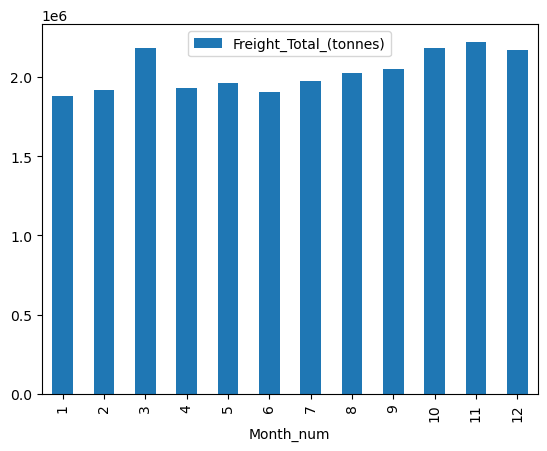

In [116]:
freight_pop_month()

In [66]:
def tot_freight():
    Freight_Tot = df[["ForeignPort","Freight_Total_(tonnes)"]].groupby("ForeignPort").sum()
    sort = Freight_Tot.sort_values([("Freight_Total_(tonnes)")],axis=0, ascending=False)
    top_freight = sort.head(10)
    top_freight.plot(kind='bar')

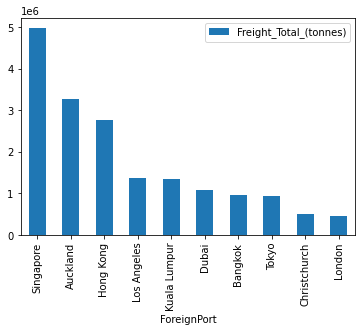

In [67]:
tot_freight()

### Mail In/Out

In [35]:
def mail_in_out():
    mail_in = df[["Year","Mail_In_(tonnes)"]].groupby("Year").sum()
    mail_out = df[["Year","Mail_Out_(tonnes)"]].groupby("Year").sum()

    plt.rcdefaults()
    plt.plot(mail_in, "x-", label = "Mail In")
    plt.plot(mail_out, "x-", label = "Mail Out")
    plt.title("Mail In/Out", fontsize=15)
    plt.xlabel('Year', fontsize=10)
    plt.ylabel('Mail(tonnes)', fontsize=10)
    plt.legend()
    plt.grid(True)
    plt.show()

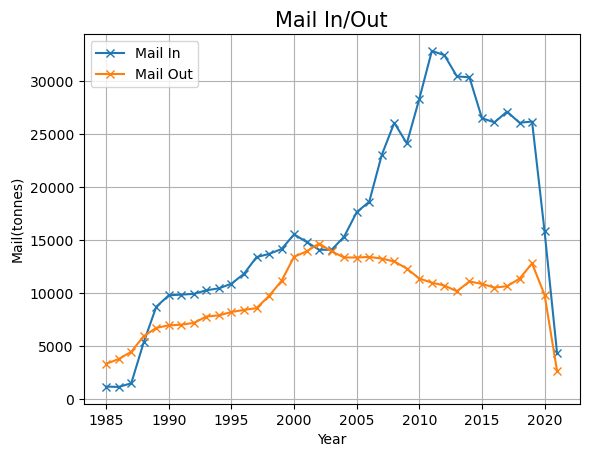

In [36]:
mail_in_out()

In [9]:
df.head()

,Month,AustralianPort,ForeignPort,Country,Passengers_In,Freight_In_(tonnes),Mail_In_(tonnes),Passengers_Out,Freight_Out_(tonnes),Mail_Out_(tonnes),Passengers_Total,Freight_Total_(tonnes),Mail_Total_(tonnes),Year,Month_num,Month_name
0,31048,Adelaide,Auckland,New Zealand,1513.0,42.167,0.311,985.0,18.704,0.924,2498.0,60.871,1.235,1985,1,Jan
1,31048,Adelaide,Bahrain,Bahrain,12.0,0.000,0.000,5.0,0.033,0.000,17.0,0.033,0.000,1985,1,Jan
2,31048,Adelaide,Bombay,India,7.0,0.000,0.000,5.0,0.000,0.000,12.0,0.000,0.000,1985,1,Jan
3,31048,Adelaide,Frankfurt,Germany,115.0,0.009,0.000,171.0,0.000,0.248,286.0,0.009,0.248,1985,1,Jan
4,31048,Adelaide,London,UK,1567.0,2.800,0.000,1472.0,10.618,2.487,3039.0,13.418,2.487,1985,1,Jan


In [52]:
def in_vs_out_mail_month():  
    v = df[["Month_num", "Month_name", "Mail_In_(tonnes)", "Mail_Out_(tonnes)"]].groupby("Month_num").sum()
    ax = v.plot.bar(rot=0)

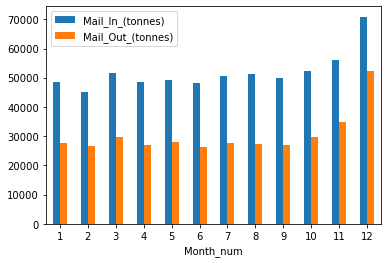

In [53]:
in_vs_out_mail_month() 

loads the world map and cites dataset

In [8]:
 world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
 cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

### Destinations in 1985

In [64]:
def destinations_eighties():
    # port_df = data frame with long/lat + name + location - only has unique cities
    # long_lat = data frame with just unique long/lat
    # df_long_lat = big data frame now containing the long and lat - takes longer if its used
    # the data frame with the long and lat coordinates 
    data = df_long_lat[(df_long_lat.Year == 1985)]

    # tells python the coordinate system
    crs ={'init':'epsg:4326'}
    # defines the geometry
    geometry = [Point(xy) for xy in zip(data["longitude"], data["latitude"])]

    # loads data from geopandas
    geodata = gpd.GeoDataFrame(data,crs=crs, geometry=geometry)


    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Formatting stuff is below like colour, text etc
    fig, ax = plt.subplots(figsize=(15,7))

    world.plot(ax=ax, facecolor='Grey', edgecolor='k',alpha=1,linewidth=0.1,color='grey')

    port_geo = data[["port", "geometry","longitude","latitude"]]
    text_unique = []
    for idx, row in port_geo.iterrows():
        #the if statement avoids duplicate names
        if row.port in text_unique:
            continue
        else:
            plt.annotate(text=row.port, xy=tuple(row.geometry.coords)[0], xycoords='data', fontsize=6)
            text_unique.append(row.port)

    #cmaps is the colour map - can check matplotlib for all the colour maps 

    geodata.plot(ax=ax, color='red', markersize=5)  
    fig.suptitle('Destinations in 1985', fontsize=12)
    ax.set_xlabel('Longitude', fontsize=10)
    ax.set_ylabel('Latitude', fontsize='medium')

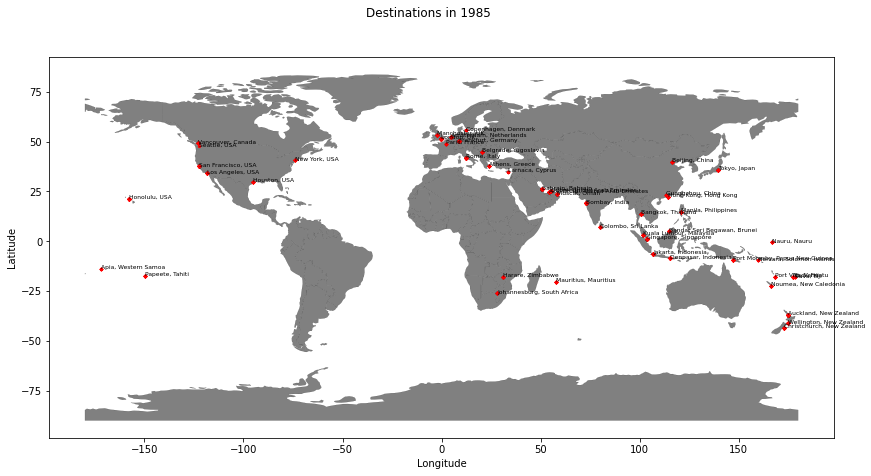

In [65]:
destinations_eighties()

### Destinations in 2019

In [10]:
def destinations_twenties():
    # port_df = data frame with long/lat + name + location - only has unique cities
    # long_lat = data frame with just unique long/lat
    # df_long_lat = big data frame now containing the long and lat - takes longer if its used
    # the data frame with the long and lat coordinates 
    data = df_long_lat[(df_long_lat.Year == 2019)]

    # tells python the coordinate system
    crs ={'init':'epsg:4326'} 
    # defines the geometry
    geometry = [Point(xy) for xy in zip(data["longitude"], data["latitude"])]

    # loads data from geopandas
    geodata = gpd.GeoDataFrame(data,crs=crs, geometry=geometry)

    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Formatting stuff is below like colour, text etc
    fig, ax = plt.subplots(figsize=(15,7))

    world.plot(ax=ax, facecolor='Grey', edgecolor='k',alpha=1,linewidth=0.1,color='grey')

    port_geo = data[["port", "geometry","longitude","latitude"]]
    text_unique = []
    for idx, row in port_geo.iterrows():
        #the if statement avoids duplicate names
        if row.port in text_unique:
            continue
        else:
            plt.annotate(text=row.port, xy=tuple(row.geometry.coords)[0], xycoords='data', fontsize=6)
            text_unique.append(row.port)


    #change markersize to be proportional to value counts

    # # datab = data.ForeignPort.value_counts(dropna=False)
    # data['values'] = data.groupby("port").size()
    # # cities.plot(markersize=cities['values'])
    # just_counts = data.port
    # df_just_counts = just_counts.value_counts().rename_axis('unique_values').to_frame('counts')


    #cmaps is the colour map - can check matplotlib for all the colour maps 

    geodata.plot(ax=ax, color='red', markersize=5)  
    fig.suptitle('Destinations in 2019', fontsize=12)
    ax.set_xlabel('Longitude', fontsize=10)
    ax.set_ylabel('Latitude', fontsize='medium')

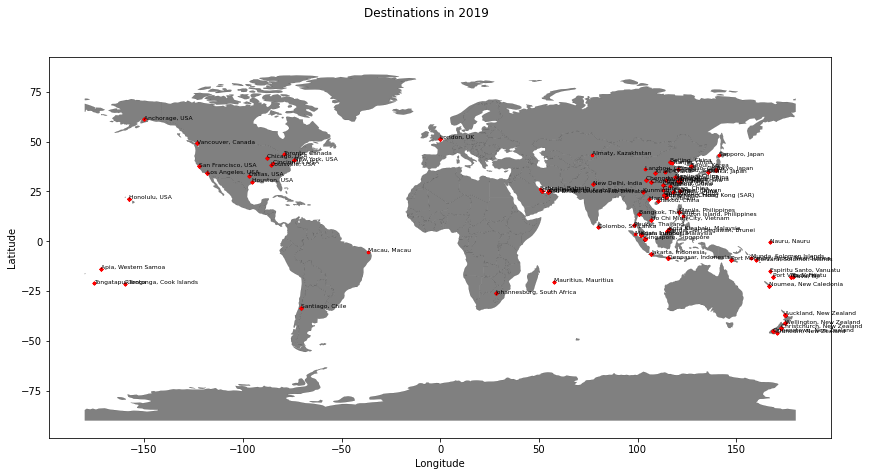

In [11]:
destinations_twenties()

In [ ]:
# map = folium.Map(location = [13.406,80.110], tiles = "Stamen Terrain", zoom_start = 9)

# map.add_child(folium.Marker(location = coordinates,
#                             popup =
#                             "Year: " + str(df_long_lat.Year[i]) + '<br>' +
#                             "port: " + str(df_long_lat.port[i]) + '<br>' +
#                             "Coordinates: " + str(df_long_lat_list[i]),
#                             icon = folium.Icon(color = "%s" % type_color)))
# map